In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Model Refinements

We explicitly use the refactored output of Notebook 2. This guarantees that any improvement in performance is attributable to feature engineering, not accidental leakage.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [17]:
data_path = "C:/Users/SHANIA/Downloads/Metro-Manila-Flood-Insights/Data/AEGISDataset_processed_refined.csv"
df = pd.read_csv(data_path)

df.head()


,lat,lon,flood_heig,elevation,precipitat,elevation_bin,precip_bin,flood_risk_index,flood_risk_index_scaled,cluster_id,cluster_mean_elev,cluster_mean_precip,cluster_mean_flood,elev_precip_interaction,low_elev_high_rain,very_low_elev,very_high_rain
0,14.640394,121.055708,0,54.553295,9.0,Very High,Low,0.834528,0.087329,17,52.868351,10.234310,2.037657,0.164674,0,0,0
1,14.698299,121.002132,0,21.856272,10.0,Moderate,Low,1.238192,0.129570,14,12.199577,9.056338,1.915493,0.455451,0,0,0
2,14.698858,121.100261,0,69.322807,16.0,Very High,High,1.007032,0.105380,10,31.323989,15.278351,2.948454,0.230472,0,0,0
3,14.571310,120.983334,0,10.987241,8.0,Low,Low,1.261310,0.131989,19,9.217746,7.972222,2.384259,0.721550,0,0,0
4,14.762232,121.075735,0,87.889847,18.0,Very High,High,0.900089,0.094189,4,54.221978,13.095238,2.440476,0.204569,0,0,0


In [18]:
y = df['flood_heig']

X = df.drop(columns=[
    'flood_heig',
    'flood_risk_index',            # avoid conceptual overlap
    'flood_risk_index_scaled'      # avoid leakage
])


Flood height is measurable and actionable. Risk scores are for interpretation, not prediction.

In [19]:
numeric_features = [
    'lat','lon','elevation','precipitat',
    'cluster_mean_elev','cluster_mean_precip','cluster_mean_flood',
    'elev_precip_interaction',
    'low_elev_high_rain','very_low_elev','very_high_rain'
]

categorical_features = [
    'elevation_bin','precip_bin','cluster_id'
]


This separation allows models to treat measurements and categories appropriately without manual errors.

In [20]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore'
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


This codeblock ensures consistency. Every future retrain applies the same transformations.

In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [23]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [24]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 1.870
R²: -0.003


RMSE: Average prediction error in flood height units

R²: How much of flooding behavior we can explain using our data

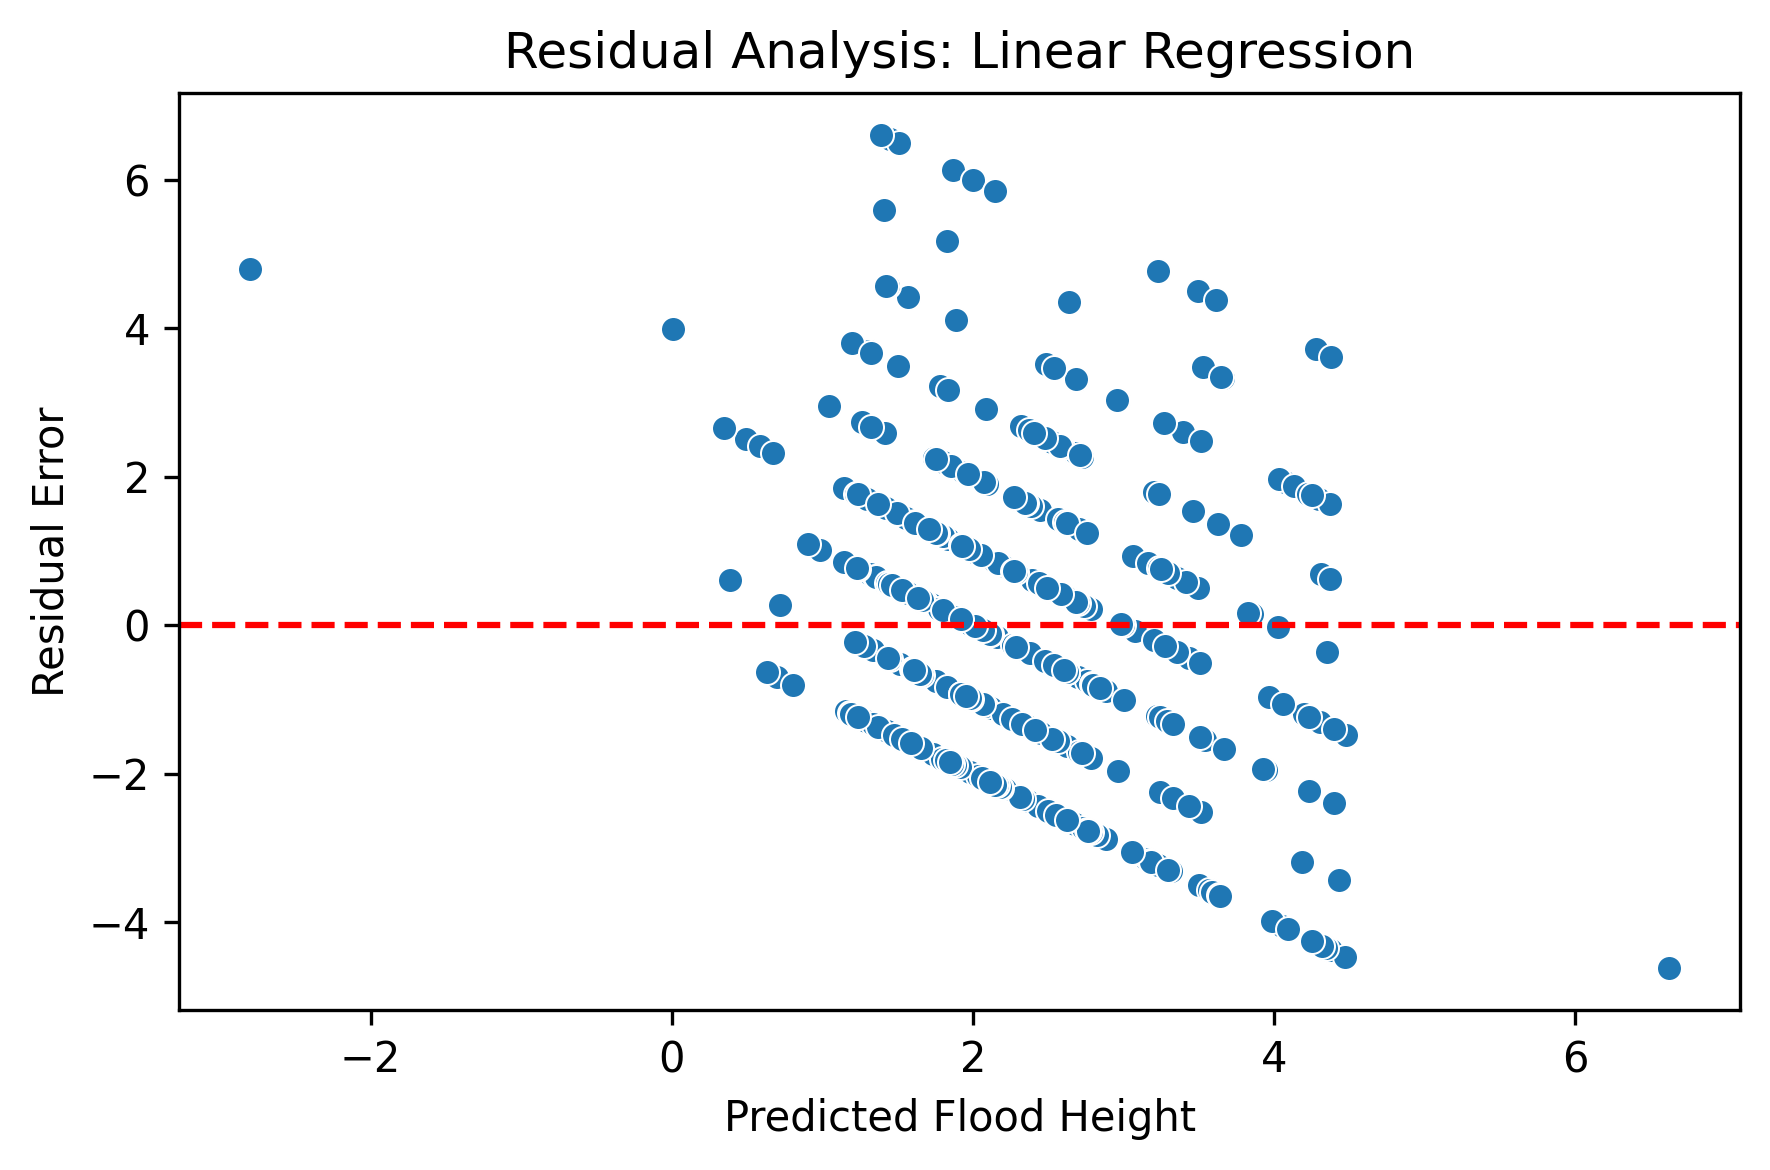

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4), dpi=300)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Flood Height")
plt.ylabel("Residual Error")
plt.title("Residual Analysis: Linear Regression")
plt.tight_layout()
plt.show()


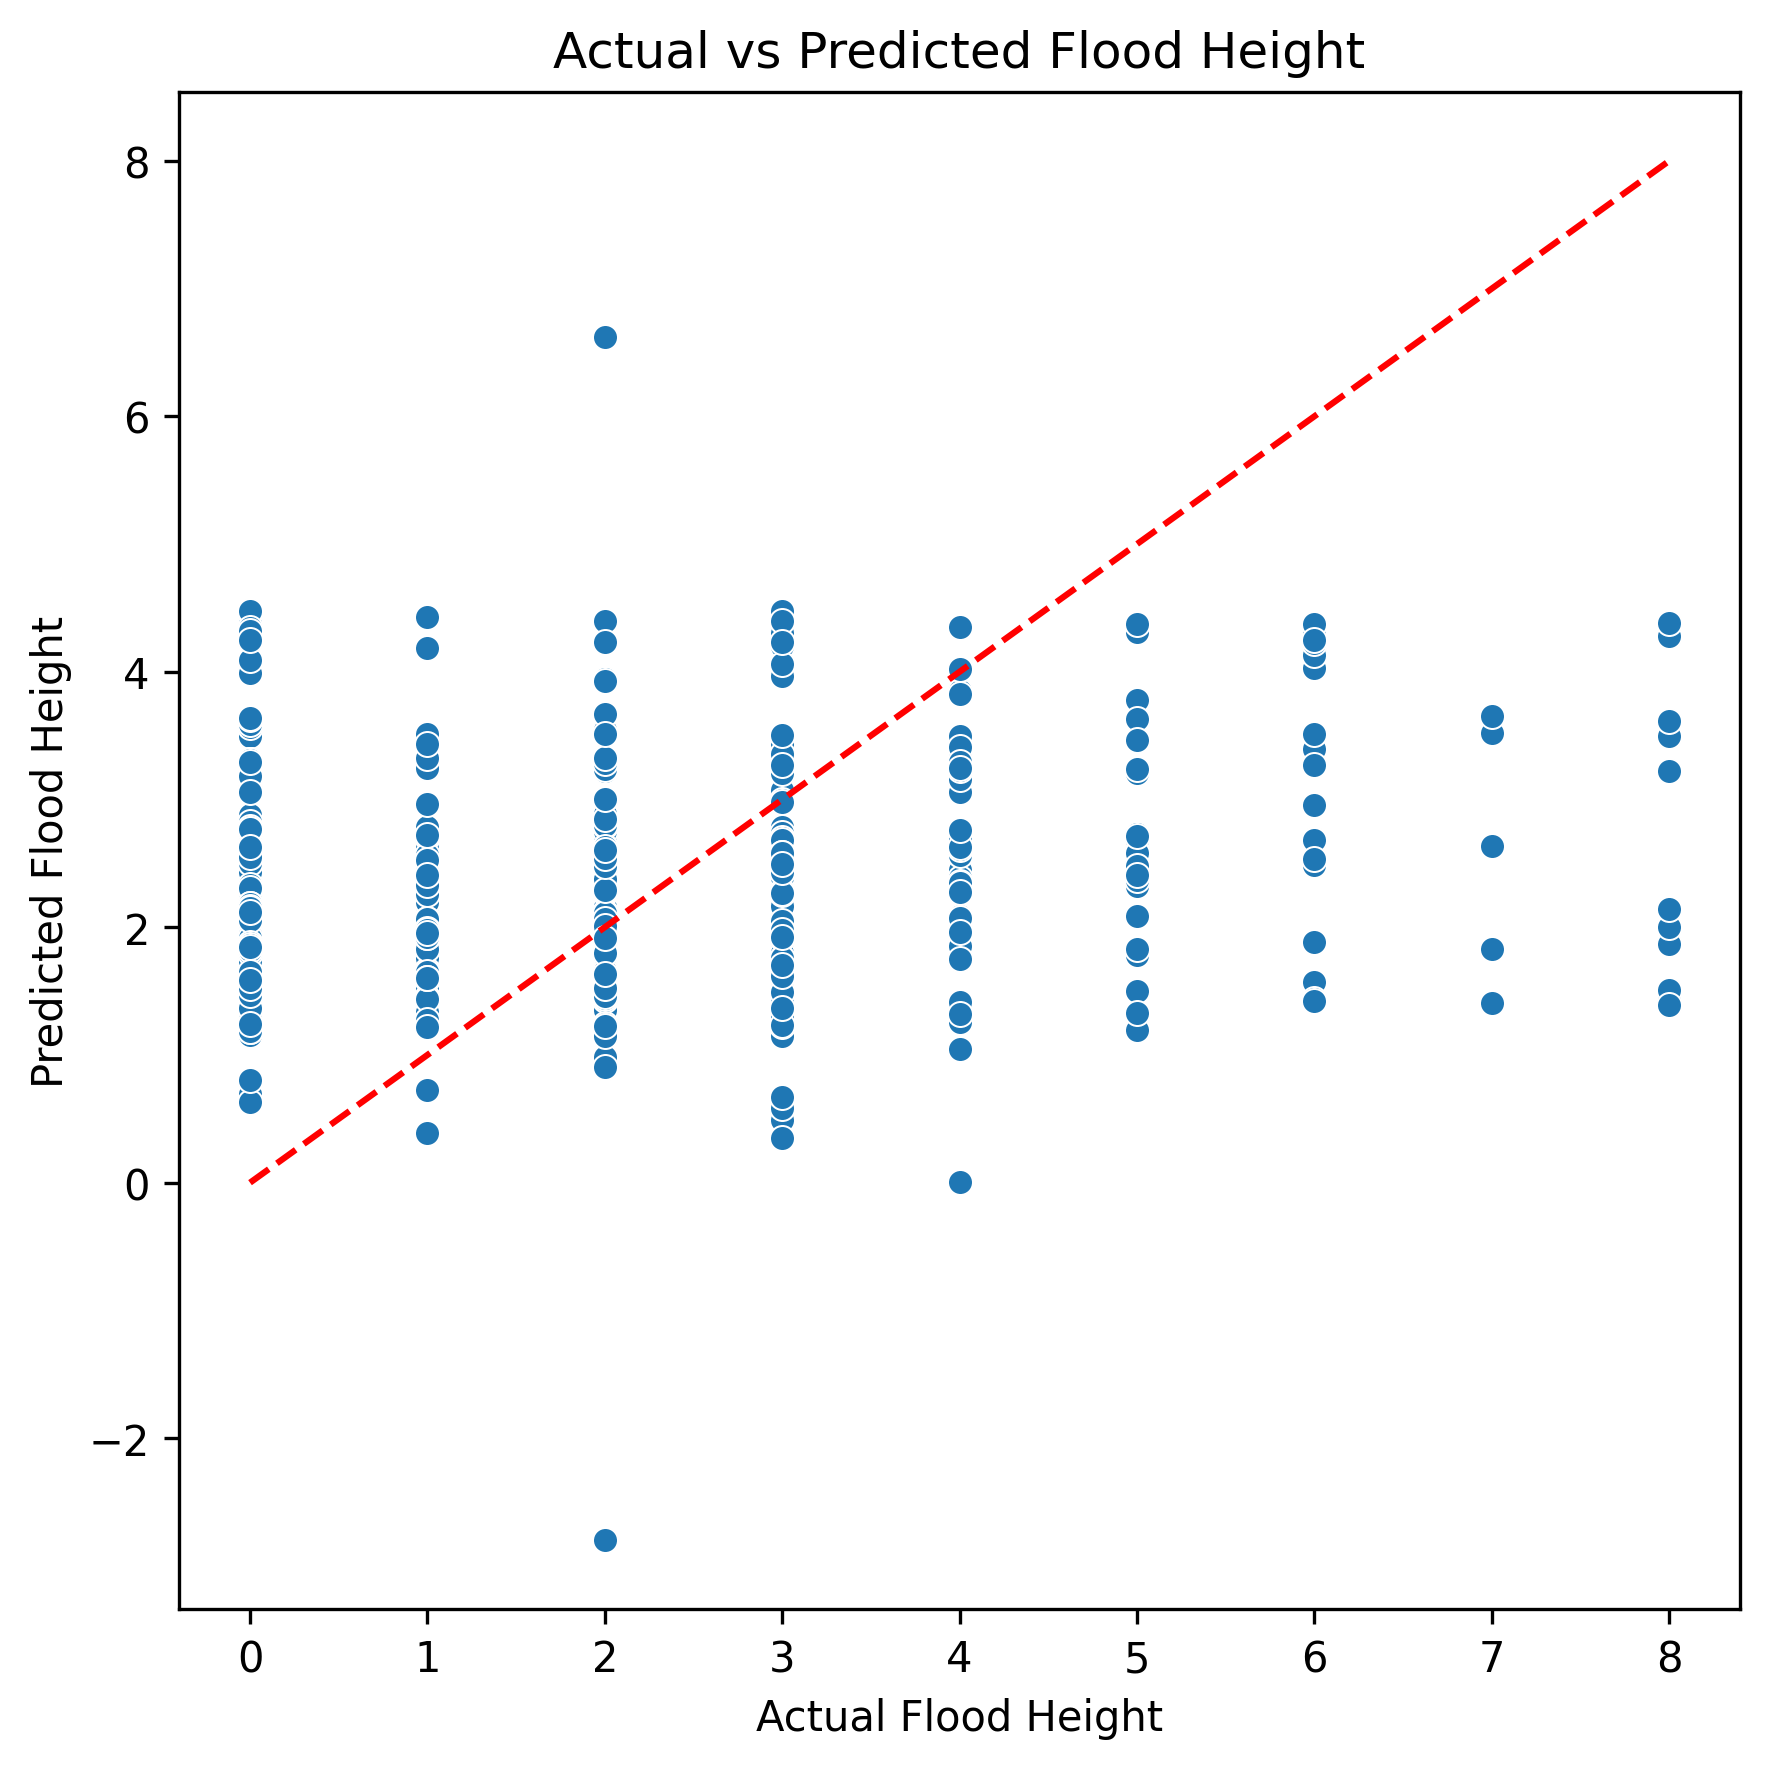

In [26]:
plt.figure(figsize=(6,6), dpi=300)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Flood Height")
plt.ylabel("Predicted Flood Height")
plt.title("Actual vs Predicted Flood Height")
plt.tight_layout()
plt.show()
